Features used: ['mean', 'std', 'abs_sentiment_score', 'news_count', 'is_option_expiry', 'is_first_trading_day', 'is_last_trading_day', 'is_last_trading_day_of_quarter', 'Friday', 'Monday', 'Thursday', 'Tuesday', 'Wednesday']
[0]	validation_0-rmse:1.42524
[10]	validation_0-rmse:1.30096
[20]	validation_0-rmse:1.22023
[30]	validation_0-rmse:1.16588
[40]	validation_0-rmse:1.12338
[50]	validation_0-rmse:1.09593
[60]	validation_0-rmse:1.08788
[70]	validation_0-rmse:1.08260
[80]	validation_0-rmse:1.08263
[90]	validation_0-rmse:1.08424
[100]	validation_0-rmse:1.08478
[110]	validation_0-rmse:1.08746
[120]	validation_0-rmse:1.09303
[130]	validation_0-rmse:1.09720
[134]	validation_0-rmse:1.09905


/var/folders/zb/wl4qyrb96w75tjlwvrwzzyz80000gn/T/ipykernel_49484/2906061471.py:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')



Test Set Evaluation Metrics:
MSE: 1.16
RMSE: 1.08
MAE: 0.85


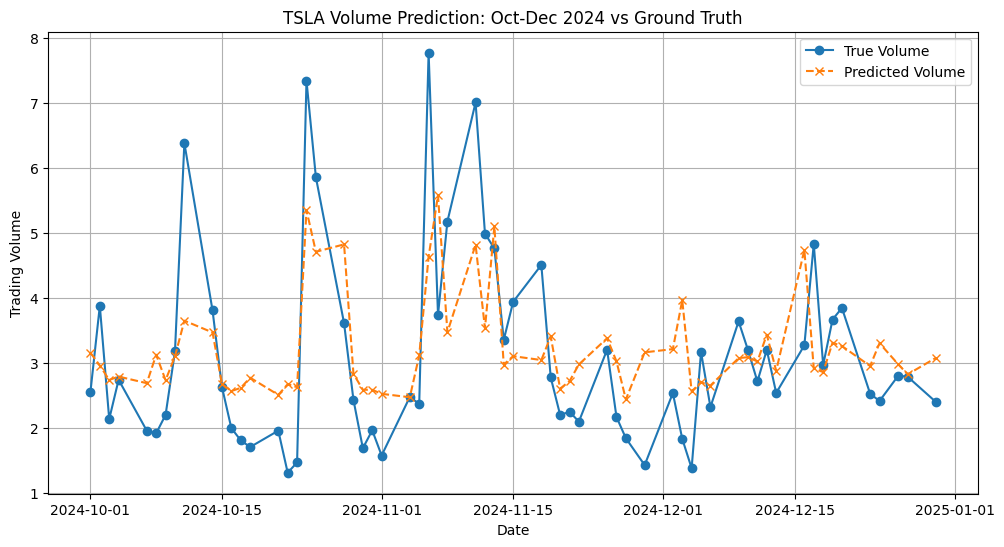


Top 10 Features (by gain importance):
news_count: 4.14
Tuesday: 1.81
mean: 1.67
Friday: 1.65
abs_sentiment_score: 1.56
is_first_trading_day: 1.54
Thursday: 1.37
is_last_trading_day: 1.17
std: 1.11
Monday: 1.03


In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# --------------------------
# 1. Data Loading and Preprocessing
# --------------------------
# Read CSV file (assuming the date format is YYYY-MM-DD)
df = pd.read_csv('../data/tsla.csv', parse_dates=['date'])
df = df.sort_values('date').set_index('date')  # Sort by date and set it as index

# Handle missing values (forward fill)
df.drop(columns=['day_total_vol'], inplace=True)
df = df.fillna(method='ffill')

# --------------------------
# 2. Define Training and Testing Sets
# --------------------------
# Split data strictly based on time range
train = df.loc['2024-01-01':'2024-09-30']  # Assuming data is from 2024
test = df.loc['2024-10-01':'2024-12-31']

# Define target variable and features
target = 'TSLA_first_hour_vol'
features = [col for col in df.columns if col != target]
print("Features used:", features)

X_train, y_train = train[features], train[target]
X_test, y_test = test[features], test[target]

# --------------------------
# 3. Train XGBoost Model
# --------------------------
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    early_stopping_rounds=50,
    random_state=42
)

# Train the model using the test set as a validation set (for early stopping)
model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],  # Monitor performance on test set
    verbose=10
)

# --------------------------
# 4. Model Evaluation and Visualization
# --------------------------
# Predict on the test set
y_pred = model.predict(X_test)

# Compute evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
print(f"\nTest Set Evaluation Metrics:")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

# Visualization of Predictions vs Ground Truth
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='True Volume', marker='o')  # True values
plt.plot(y_test.index, y_pred, label='Predicted Volume', linestyle='--', marker='x')  # Predicted values
plt.title('TSLA Volume Prediction: Oct-Dec 2024 vs Ground Truth')
plt.xlabel('Date')
plt.ylabel('Trading Volume')
plt.legend()
plt.grid(True)
plt.show()

# --------------------------
# 5. Feature Importance Analysis
# --------------------------
# Get feature importance based on gain
importance = model.get_booster().get_score(importance_type='gain')
importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)

# Print top 10 important features
print("\nTop 10 Features (by gain importance):")
for feat, score in importance[:10]:
    print(f"{feat}: {score:.2f}")
